# Sentiment Analysis with an RNN & Transfer Learning

[情感分析](https://en.wikipedia.org/wiki/Sentiment_analysis)是指使用自然语言处理，文本分析，计算语言学和生物识别技术来系统地识别，提取，量化和研究情感状态和主观感受。情绪分析应用广泛，例如在线评论和市场调查反馈，社交媒体，互联网医疗保健服务，营销以及客户推荐系统。

[自然语言处理](https://en.wikipedia.org/wiki/Natural_language_processing)（NLP）是机器学习技术重要应用范畴之一，有研究人员预测未来的人机交互的界面大部分将由能处理自然语言的智能产品替代， 它们能听懂人类的语言。目前已经有初具规模的应用雏形，例如手机上的智能语音助理如Siri，移动、联通的自动语音服务，具有理解、推理能力的[IBM Waston](http://www.ibm.com/watson/)，亚马逊的高级语音识别及自然语言理解功能的[Lex](https://aws.amazon.com/cn/lex/)，等等。

​自然语言处理面临诸多挑战之一就是词、语句以及文章的表达。统计语言处理[ngram模型](http://blog.csdn.net/ahmanz/article/details/51273500) ，计算两个单词或者多个单词同时出现的概率，但是这些符号难以直接表示词与词之间的关联，也难以直接作为机器学习模型输入向量。对句子或者文章的表示[词袋子模型](http://www.cnblogs.com/platero/archive/2012/12/03/2800251.html)，即将段落或文章表示成一组单词，例如两个句子：”她喜欢猫猫.“、”他也喜欢猫猫.“ 我们可以构建一个词频字典：{"她": 1, "他": 1, "喜欢": 2 "猫": 4, "也": 1}。根据这个字典, 我们能将上述两句话重新表达为下述两个向量: [1, 0, 2，0]和[0, 1, 1, 2, 1]，每1维代表对应单词的频率。这些词向量可以作为机器学习模型的输入数值向量，但是它们依然难以表达关联性，而且当词库单词量庞大时，编码的维度十分巨大，给计算和存储带来不少问题。

Mikolov、Socher等人提出了[Word2Vec](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)、[GloVec](http://nlp.stanford.edu/pubs/glove.pdf)等词向量模型，能够比较好的解决这个问题，即用维数较少的向量表达词以及词之间的关联性。然而，这些用于学习词向量的方法仅考虑每个单词在独立的上下文表示。即没有很好的解决一个词在不同的上下文可能会有不同的含义。Peters等人提出的[ELMo](https://arxiv.org/pdf/1802.05365.pdf)就针对这个问题提出了“深度语境化词表示法”较好解决方案。他们认为单词的含义取决于上下文，它们的词向量也应考虑上下文。ELMo模型使用多层双向LSTM语言模型进行半监督学习来获取每个词向量时，将整个句子或段落都考虑在内。这使得ELMo模型在各种NLP任务中都有不错的性能的提高。Devlin等人提出的[BERT](https://arxiv.org/pdf/1810.04805.pdf)是目前深度学习的主要突破之一，在NLP中开发了有效的迁移学习方法。BERT(Deep Bidirectional Transformers)模型摒弃的LSTM层而是使用了Self-attention层。由于其强大的性能，BERT将会在未来几年继续成为NLP的主要方法。BERT的开发者提供了中文的预训练模型。为使用中文语言处理的开发者提供的很大的便利。

这里，实现二个模型，一个单纯的LSTM模型， 一个基于BERT预训练模型为基础的迁移学习。对餐馆在线评论的数据集进行训练建模。

---
### Load in and visualize the data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import numpy as np
from pathlib import Path
import pandas as pd
import os
import re
import jieba
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# check the source dataframe

df = pd.read_csv('./data/dianping.csv')
print("The total number of reviews:", df.shape[0])

df.head()

The total number of reviews: 2000


,comment,sentiment
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0
1,菜品丰富质量好，服务也不错！很喜欢！,1
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1


## 数据探索和数据预处理

建立神经网络模型的第一步是将数据转换为适当的形式以输入网络。 由于使用的是嵌入层，因此需要使用整数对每个单词进行编码。 并且还需要对其进行清理。

首先对于每个评论，
1. 根据CJK统一表意文字(CJK Unified Ideographs)的Unicode块提取有效的汉字字符。
2. 进行分词，使用结巴（https://github.com/fxsjy/jieba ）

In [3]:
# is there any missing value

df.isna().sum()

comment      0
sentiment    0
dtype: int64

In [4]:
# how many postive review and negative review

print(f"Postive reviews: {len(df[df['sentiment'] == 1])}")
print(f"Negative reviews: {len(df[df['sentiment'] == 0])}")

Postive reviews: 1000
Negative reviews: 1000


In [5]:
# what the review looks like

def pretty_print(i):
    print(str(df['sentiment'][i]) + "\t:\t" + df['comment'][i][:50] + "...")
    
print("labels \t:\treviews\n")
pretty_print(211)
pretty_print(128)
pretty_print(62)
pretty_print(341)
pretty_print(597)
pretty_print(498)

labels 	:	reviews

1	:	今天第一次去还挺好的环境也很不错...
1	:	菜不贵，排队的人很多。服务员误导，菜量很大还使劲让我们点，问他是不是有点多，他说三个人点十个菜的都有...
1	:	口味还行 人太多 排队不开心 价格偏贵...
0	:	环境确实不错，在大学城骑鹅公社内，靠窗的位置不多，味道真心不如白堤路凤荷园那家，价位比凤荷园贵，味道...
0	:	真心不好吃 和北京吃的北京菜没法比 除了猪肝还过得去 别的实在难吃啊...
0	:	真不知道五颗星哪来的 朋友之前来过 说还可以 然后味道是真的不行 烤肉什么的也不好吃 鱿鱼硬的嚼不动...


In [6]:
# define and initialize the 3-party libaray object - jieba (https://github.com/fxsjy/jieba)
# https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)

jieba.initialize()
REGEX = re.compile(r'[^\u4e00-\u9fa5aA-Za-z0-9]')

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/7v/r6htqywj1psc66gmv2275kb40000gn/T/jieba.cache
Loading model cost 0.838 seconds.
Prefix dict has been built succesfully.


In [7]:
# define tokenization function

def tokenizer(sent):
    '''
    usint 3-party libary jieba to tokenize the text
    '''
    line = REGEX.sub(' ', sent)

    return list(filter(lambda x: x.strip(), jieba.cut(line)))

### 词编码

对于网络的嵌入层输入，要求我们将每个评论转换成数值组形式。 最简单的方法是创建字典，将词汇表中的词映射为整数。 然后，我们可以将每个评论转换为整数数组，以便将其传递到网络中。

In [8]:
# perform tokenization
comments = df['comment'].to_list()

new_comments = []
for e in comments:
    new_comments.append(tokenizer(e))

# all review as tokens
all_cn = []
for sent in new_comments:
    all_cn.extend([w for w in sent])

# all token counts
cnt = Counter(all_cn)

# build vocabulary
vocab = sorted(cnt, key=cnt.get, reverse=True)

In [9]:
# test for first review

# line = REGEX.sub(' ',comments[0])
# print(line)
# print(list(filter(lambda x: x.strip(), jieba.cut(line))))

In [10]:
# 20 most frequent words

vocab_20 = cnt.most_common(20)
#vocab_20

In [11]:
# postive reviews
p_comments = df[df['sentiment'] == 1]['comment'].to_list()

post_comments = []
for e in p_comments:
    post_comments.append(tokenizer(e))
    
post_cn = []
for s in post_comments:
    post_cn.extend([w for w in s])

# all token counts
post_cnt = Counter(post_cn)

# 20 most common words in postive reviews
post_20 = post_cnt.most_common(20)
#post_20

In [12]:
# negative review
ng_comments = df[df['sentiment'] == 0]['comment'].to_list()

neg_comments = []
for e in ng_comments:
    neg_comments.append(tokenizer(e))

neg_cn = []
for s in neg_comments:
    neg_cn.extend([w for w in s])

# all token counts
neg_cnt = Counter(neg_cn)

# 20 most common words in negative reviews
neg_20 = neg_cnt.most_common(20)
#neg_20

可以看到，正面和负面评论中都经常出现诸如“的”之类的常用词。 我们真正想要的不是在正面或负面评论中找到最常见的词，而是在正面评论中比在负面评论中发现更多的词，反之亦然。 为此，计算正面和负面评论之间单词使用的*比例* 可能是比较好对特征。

在对数取比率后，中性词将接近`0`，当词的比率趋近并高于`1`时，词将变得更正；当词的比率趋近并低于`-1`时，词将变得更负。

In [13]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term, c in list(cnt.most_common()):
    if(c > 100):
        pos_neg_ratio = post_cnt[term] / float(neg_cnt[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [14]:
print("Pos-to-neg ratio for '的' = {}".format(pos_neg_ratios["的"]))
print("Pos-to-neg ratio for '好吃' = {}".format(pos_neg_ratios["好吃"]))
print("Pos-to-neg ratio for '失望' = {}".format(pos_neg_ratios["失望"]))

Pos-to-neg ratio for '的' = 0.8303972366148532
Pos-to-neg ratio for '好吃' = 2.0386740331491713
Pos-to-neg ratio for '失望' = 0.26744186046511625


In [15]:
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [16]:
print("Pos-to-neg ratio for '的' = {}".format(pos_neg_ratios["的"]))
print("Pos-to-neg ratio for '好吃' = {}".format(pos_neg_ratios["好吃"]))
print("Pos-to-neg ratio for '难吃' = {}".format(pos_neg_ratios["难吃"]))

Pos-to-neg ratio for '的' = -0.1858510943519974
Pos-to-neg ratio for '好吃' = 0.7122996127747014
Pos-to-neg ratio for '难吃' = -3.6375861597263857


In [17]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

mpl.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'SimHei',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

Text(0.5, 1, '词(全部)的使用频率')

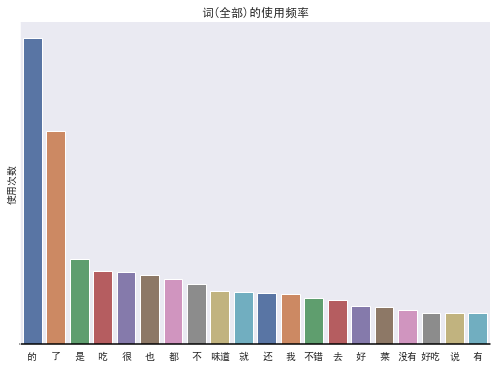

In [18]:
f, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
x1 = [vocab_20[i][0] for i in range(len(vocab_20))]
y1 = [vocab_20[i][1] for i in range(len(vocab_20))]

sns.barplot(x=x1, y=y1, palette="deep", ax=ax,)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("使用次数")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], )
plt.tight_layout(h_pad=2)
plt.title('词(全部)的使用频率')

Text(0.5, 1, '词(正向)的使用频率')

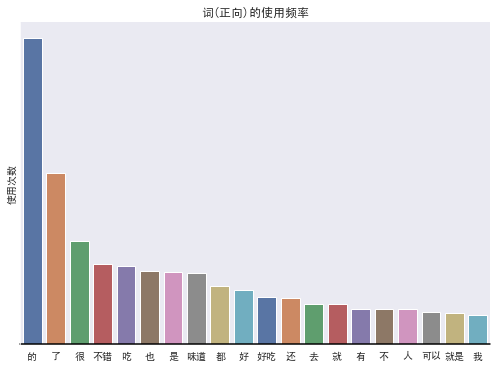

In [19]:
f, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
x2 = [post_20[i][0] for i in range(len(post_20))]
y2 = [post_20[i][1] for i in range(len(post_20))]

sns.barplot(x=x2, y=y2, palette="deep", ax=ax,)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("使用次数")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], )
plt.tight_layout(h_pad=2)
plt.title('词(正向)的使用频率')

Text(0.5, 1, '词(负向)的使用频率')

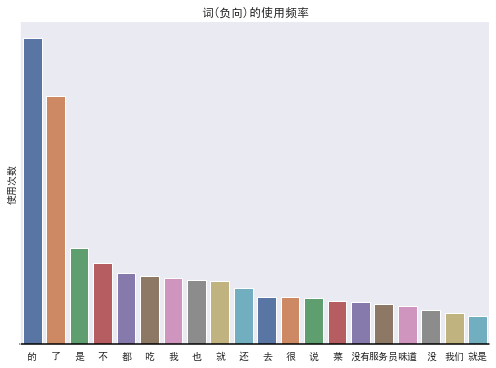

In [20]:
f, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

x3 = [neg_20[i][0] for i in range(len(neg_20))]
y3 = [neg_20[i][1] for i in range(len(neg_20))]
    
sns.barplot(x=x3, y=y3, palette="deep", ax=ax,)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("使用次数")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], )
plt.tight_layout(h_pad=2)
plt.title('词(负向)的使用频率')

Text(0.5, 1.0, '正向，负向评论次数')

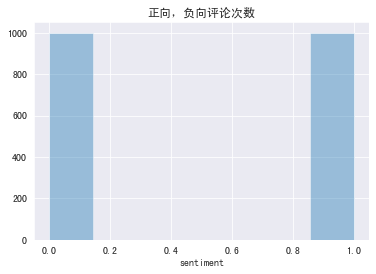

In [21]:
#f, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

    
sns.distplot(df['sentiment'],kde = False)
plt.title('正向，负向评论次数')

The minimum length of the reviews: 4
The maximum length of the reviews: 535


Text(0.5, 1.0, '评论长度分布')

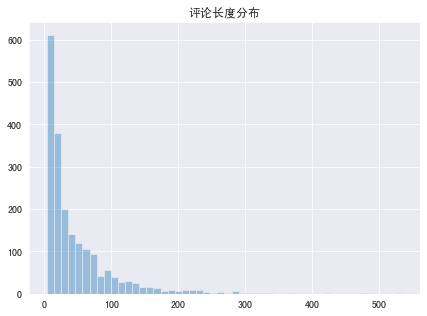

In [22]:
comm_size = np.array([len(e) for e in new_comments])

print(f"The minimum length of the reviews: {comm_size.min()}")
print(f"The maximum length of the reviews: {comm_size.max()}")

plt.figure(figsize=(7, 5))
sns.distplot(comm_size, kde = False)
plt.title('评论长度分布')

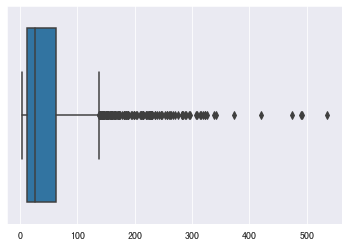

In [23]:
# the box plot (or box-and-whisker plot) shows the distribution of review length

ax = sns.boxplot(x=comm_size)

In [24]:
# build a dictionary that maps words to integers

vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
print(f"The size of vocabulary: {len(vocab_to_int)}")

The size of vocabulary: 9523


In [25]:
# use the dict to tokenize each review in new_comments
# store the tokenized reviews in reviews_ints

reviews_ints = []
for com in new_comments:
    reviews_ints.append([vocab_to_int[word] for word in com])


In [26]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int))) 

# print tokens in first review
print('\nTokenized review: \n', reviews_ints[:1])

Unique words:  9523

Tokenized review: 
 [[46, 8, 68, 3, 4401, 192, 2, 38, 96, 281, 573, 12, 45, 46, 354, 5, 32, 5, 32, 73, 551, 230, 4402, 19, 16, 7, 3, 240, 953, 1, 711, 7, 8, 451, 39, 474, 97, 845, 3103, 3103, 1, 67, 674, 4403, 1773, 1396, 36, 2042, 355, 373, 354, 13, 41, 1157, 244, 1774, 40, 32, 34, 2433, 15, 41, 6, 2434, 119, 32, 202, 119, 7, 120, 574, 21, 888, 2, 43, 5, 1158, 109, 8, 43, 505, 1261, 2043, 452, 14, 846, 43, 10, 389, 2, 4404, 1538, 4405, 3104, 12, 1011, 44, 1012, 198, 20, 1775, 551, 8, 4406, 33, 60, 149, 2435, 522, 4407, 847]]


In [27]:
# the labels

encoded_labels = np.array(df['sentiment'].to_list())
encoded_labels 

array([0, 1, 0, ..., 0, 1, 1])

---
## 填充输入数组

为了处理简短的和非常长的评论，将对所有评论填充或截断为特定长度。 对于短于`seq_length`的评论将填充0。 对于长度超过`seq_length`的评论，可以将其截断为前`seq_length`个词。


In [28]:
def pad_features(reviews_ints, seq_length):
    '''     
    INPUT 
    reviews_ints - numerised reviews
    seq_length - sequence length
    
    OUTPUT 
    Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    features=[]
    
    for comm in reviews_ints:
        if len(comm) <= seq_length:
            features.append([0] * (seq_length - len(comm)) + comm)
        else:
            features.append(comm[:seq_length])
    
    return np.array(features)

In [29]:
# test code

seq_length = 100

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[  46    8   68    3 4401  192    2   38   96  281]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 955   12  462  107 4413 1081  297   10  132   33]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 714 2049    2  347   54 4426 4427  202   95 1776]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 104   21    4 1268  888   54    2  236  375  716]
 [   0    0    0    0    0    0    0    0    0    0]
 [  28  104 1162    1   29   82  892 3126   66   34]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0

In [30]:
features.shape

(2000, 100)

## 训练，验证，测试集划分



In [31]:
split_frac = 0.8

# split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))




			Feature Shapes:
Train set: 		(1600, 100) 
Validation set: 	(200, 100) 
Test set: 		(200, 100)


### Baseline model

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [33]:
# define pipeline with SVC
pipeline = Pipeline([
            ('tfidf', TfidfTransformer()),
            ('clf', SVC())
        ])

parameters = {
        'tfidf__use_idf': (True, False),
        'clf__C': (1e-01, 1e+00, 1e+01, 1e+02),
        'clf__gamma':( 1e-01, 1e+00, 1e+01),
    }
    
# create gridsearch object and return as final model pipeline
model = GridSearchCV(pipeline, param_grid=parameters, cv=5,)

model.fit(train_x, train_y)

y_pred = model.predict(test_x)
    
acc = (y_pred == test_y).mean()

print("SVC accuracy ", acc)
print("best", model.best_estimator_)

SVC accuracy  0.565
best Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1.0,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [34]:
# using hyperopt library

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, train_x, train_y).mean()


# define hyperopt search space

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50,5))
    }
])

# space1 = hp.choice('classifier_type', [
#     {
#         'type': 'naive_bayes',
#         'alpha': hp.uniform('alpha', 0.0, 2.0)
#     },
#     {
#         'type': 'svm',
#         'C': hp.uniform('C', 0, 10.0),
#         'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         'gamma': hp.uniform('gamma', 0, 20.0)
#     },
#     {
#         'type': 'randomforest',
#         'max_depth': hp.choice('max_depth', range(1,20,2)),
#         'max_features': hp.choice('max_features', range(1,5)),
#         'n_estimators': hp.choice('n_estimators', range(1, 200, 50)),
#         'criterion': hp.choice('criterion', ["gini", "entropy"]),
#         'scale': hp.choice('scale', [0, 1]),
#         'normalize': hp.choice('normalize', [0, 1])
#     },
#     {
#         'type': 'knn',
#         'n_neighbors': hp.choice('knn_n_neighbors', range(1,50,10))
#     }
# ])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print ('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        print ('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=50, trials=trials, )
print ('best:', best)

new best:                                             
0.5475144811949416                                    
using                                                 
knn                                                   
new best:                                                                        
0.590011781708137                                                                
using                                                                            
naive_bayes                                                                      
iters:                                                                           
50                                                                               
, acc:                                                                           
0.590011781708137                                                                
using                                                                            
{'alpha': 0.11764786904752145, 'type': 'na

---
## DataLoader和批处理

创建训练，测试和验证数据之后，可以通过以下两个步骤为该数据创建DataLoader：
1. 使用[TensorDataset](https://pytorch.org/docs/stable/data.html#)创建用于训练模型时，提供访问便利的数据格式的数据集， 该格式将输入数据集和标签数据集匹配相同的第一维。

2. 创建DataLoader并批处理我们的训练，验证和测试Tensor数据集。

```
train_data = TensorDataset（torch.from_numpy（train_x），torch.from_numpy（train_y））
train_loader = DataLoader（train_data，batch_size = 批处理大小）
```


In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [36]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[   0,    0,    0,  ...,  145,    1,  122],
        [   0,    0,    0,  ...,    1,    5,   15],
        [ 381,  101,  202,  ...,  190,    2, 3356],
        ...,
        [   0,    0,    0,  ...,   17,   52,  512],
        [   0,    0,    0,  ...,   46,  640,   34],
        [   0,    0,    0,  ..., 1361,    6,  142]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0])


---
# Sentiment Network PyTorch架构

### LSTM 架构


<img src="assets/net_arch.png" width=40%>



神经网络层如下：
1. [嵌入层](https://pytorch.org/docs/stable/nn.html#embedding)，可将词标记（整数）转换为特定大小的向量。
2. 由hidden_state大小和层数定义的[LSTM层](https://pytorch.org/docs/stable/nn.html#lstm)
3. 将LSTM层输出映射到所需output_size的完全连接的输出层
4. Sigmoid激活层，将所有输出转换为值0-1； 返回**最后一个Sigmoid输出**作为此网络的输出。


### 嵌入层

需要添加一个[embeddding layer](https://pytorch.org/docs/stable/nn.html#embedding)因为我们的词汇表中有9523个词。以热独编码为输入的效率非常低。 因此，可以使用一个嵌入层并将该层用作查找表，而不是热独编码。 也可以使用Word2Vec训练嵌入层，然后在此处加载它。 但是，可以只创建一个新层，仅将其用于降维，然后让网络学习权重就可以了。


### LSTM层

创建一个[LSTM](https://pytorch.org/docs/stable/nn.html#lstm)的循环网络，该网络具有input_size，hidden_dim，层的个数，一个dropout和batch_first参数。

大多数情况下，循环网络在多层的情况下会具有更好的性能； 2-3之间。 添加更多的层可以使网络学习真正复杂的关系。

In [37]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [38]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden

    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

## 实例化网络

首先，定义超参数。

* `vocab_size`：词汇量或输入的值，词标记的范围。
* `output_size`：需输出的大小； 输出的分类的个数数的数量（正/负）。
* `embedding_dim`：嵌入查找表中的列数； 我们嵌入的大小。
* `hidden_dim`：LSTM单元的隐藏层的神经单元的个数。 通常，越大越好。 常用值为128、256、512等。
* `n_layers`：网络中LSTM的层数。 通常在1-3之间

In [39]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(9524, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


---
## 模型训练


使用一种新型的交叉熵损失，该损失旨在与单个Sigmoid输出一起使用。 [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), 或**二元交叉熵损失**将交叉熵损失输出一个于介于0和1之间数值。

In [40]:
# Learning rate for our optimizer.
lr=0.001

# loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [41]:
# training params

# Number of times to iterate through the training dataset.
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 50

# The maximum gradient value to clip at (to prevent exploding gradients).
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 2/4... Step: 50... Loss: 0.480931... Val Loss: 0.553159
Epoch: 4/4... Step: 100... Loss: 0.072312... Val Loss: 0.667322


---
## 测试


* **测试数据性能：**首先，查看训练好的模型在test_data上运行效果。计算测试数据的平均损失和准确性。

* **关于用户生成的数据的推论：**其次，查看训练好的模型对一个不带标签的示例评论，并会产生什么预测。 

In [42]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# for classification report
labels_list = []
preds_list = []

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else \
                        np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    
    # append to list
    preds_list += pred.tolist()
    labels_list += labels.tolist()

    

# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))




Test loss: 0.706
Test accuracy: 0.780


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(labels_list, preds_list)

array([[69, 30],
       [14, 87]])

In [44]:
print(classification_report(labels_list, preds_list))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        99
           1       0.74      0.86      0.80       101

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200



### 推论

检查模型是否正确预测！

In [45]:
def tokenize_review(test_review):
    '''
    the tokenization and numerization of a review text
    '''
    # test code and generate tokenized review
    test_tok = tokenizer(test_review)

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_tok])

    return test_ints

In [46]:
def predict(net, test_review, sequence_length=200):
    '''
    INPUT
    net - the trained model
    test_review - new review which unseen for model to predict 
    sequence_length - sequence length parameter for trained model
    
    OUTPUT
    print result based on prediction
    '''
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)

    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [47]:
# test code and generate tokenized review
test_tok = tokenizer('这家的环境差，菜也不好吃。')
print(test_tok)

test_ints = [] 
test_ints.append([vocab_to_int[word] for word in test_tok])
print(test_ints)

# test sequence padding
t_features = pad_features(test_ints, seq_length)
print(t_features)

# test conversion to tensor and pass into your model
t_feature_tensor = torch.from_numpy(t_features)
print(t_feature_tensor.size())

['这家', '的', '环境', '差', '菜', '也', '不', '好吃']
[[96, 1, 36, 108, 16, 6, 8, 18]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  96   1  36 108  16   6   8  18]]
torch.Size([1, 100])


In [48]:
# negative test review
test_review_neg = '这家的环境差，菜也不好吃。'
test_review_neg2 = '这家的环境不差，但是菜不怎么好吃。'

# positive test review
test_review_pos = '这家店的味道不错。'

In [49]:
# make predictions

predict(net, test_review_neg, seq_length)

predict(net, test_review_neg2, seq_length)

predict(net, test_review_pos, seq_length)

Prediction value, pre-rounding: 0.120945
Negative review detected.
Prediction value, pre-rounding: 0.923859
Positive review detected!
Prediction value, pre-rounding: 0.987626
Positive review detected!


In [50]:
# model summary

net

SentimentRNN(
  (embedding): Embedding(9524, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [51]:
# get word embedding weights

emb_lstm = net.embedding.weight.detach().numpy()
        
emb_lstm.shape      

(9524, 400)

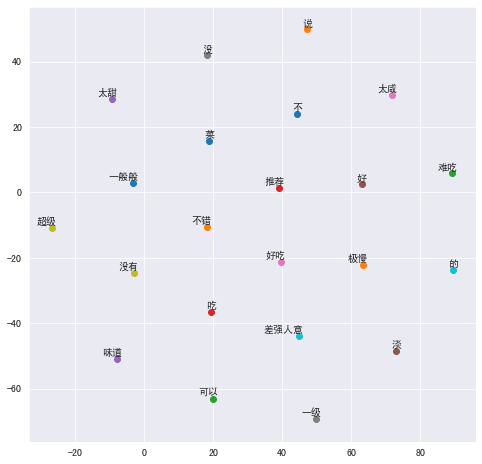

In [52]:
# visualizing some words in input space

from sklearn.manifold import TSNE

labels = ['不','不错','可以','吃','味道','好','好吃','没','没有','的','菜','说','难吃','推荐', 
             '太甜','淡', '太咸','一级','超级','差强人意','一般般','极慢']

word2int = [vocab_to_int[w] for w in labels]

tokens = [emb_lstm[i] for i in word2int]

#tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = TSNE()
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(8, 8)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

## Using Fastai Library and BERT pretrained model

### Fastai

一个开源的融合了机器学习和深度学习业界最佳实践的软件库。[参见](https://www.fast.ai/)


### BERT 

相关的主要文献。
1. BERT（来自Google）论文: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
2. GPT（来自OpenAI）论文: Improving Language Understanding by Generative Pre-Training
3. GPT-2（来自OpenAI）论文: Language Models are Unsupervised Multitask Learners
4. Transformer-XL（来自Google/CMU）论文: Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context
5. XLNet（来自Google/CMU）论文: XLNet: Generalized Autoregressive Pretraining for Language Understanding
6. XLM（来自Facebook）论文: Cross-lingual Language Model Pretraining

BERT模型是由Jacob Devlin，Ming Ming-Wei Chang，Kenton Lee和Kristina Toutanova在论文1中提出的。 这是一种双向Trnsformer，结合了Masked Language Modeling目标和下一个句子的预测，在包括多伦多图书语料库和维基百科在内的大型语料库中进行了预训练。

[一些重要的细节以及如何使用BERT](http://mlexplained.com/2019/01/07/paper-dissected-bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding-explained/)
* 语言建模是使用未标记的数据对NLP中的神经网络进行预训练
* 传统语言模型采用前n个标记，并预测下一个。 相反，BERT训练的语言模型在预测时会考虑前一个和后一个标记。
* BERT还接受了下一个句子预测任务的培训，以更好地处理需要对两个句子之间的关系进行推理的任务（例如问题回答）
* BERT使用Transformer体系结构对句子进行编码。


[BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer)

In [53]:
# import fastai library and huggingface pytorch transformers library

from fastai import *
from fastai.text import *
from pytorch_transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [54]:
# define the pre-trained BERT, RoBERTa model to use, squence max length, and batch size

bert_model = ["bert-base-chinese", "hfl/chinese-roberta-wwm-ext"]
max_seq_len = 256
batch_size = 32

In [55]:
# define the BERT tokenizer based on chinese pre-traind model

bert_tokenizer = BertTokenizer.from_pretrained(bert_model[0])

In [56]:
# find the vocabulary for the chinese characters

bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))
#bert_vocab

In [57]:
# define specific tokenizer for fastai

class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

# define token function
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

# tokenizer for fastai
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [58]:
# train, validation, test set split

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=.1, random_state=1)
train, valid = train_test_split(train, test_size=.111, random_state=1)

print(train.shape)
print(valid.shape)
print(test.shape)

(1600, 2)
(200, 2)
(200, 2)


In [59]:
# DataBunch object that is used inside Learner to train a model.
# The Databunch handles all the processing of data behind the scenes 
# and prepares the data to be passed to a Learner.

databunch = TextClasDataBunch.from_df(Path("."), train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [60]:
# show data in databunch

databunch.show_batch()

text,target
[CLS] 【 位 置 】 恒 隆 六 楼 ， 看 见 鼎 泰 丰 后 在 一 直 往 前 走 ， 排 队 人 多 的 就 是 了 。 【 环 境 】 面 积 挺 大 的 ， 可 以 容 纳 桌 数 在 恒 隆 这 些 餐 厅 里 绝 对 是 前 几 名 。 很 亮 堂 ， 就 餐 环,1
[CLS] 周 六 中 午 去 的 ， 排 队 的 人 真 的 超 级 多 ， 我 们 拿 的 号 前 面 大 概 还 有 六 十 几 桌 ， 等 了 一 个 多 小 时 左 右 ， 上 菜 的 速 度 还 是 很 快 的 ， 很 有 效 率 ， 环 境 也 不 错 。 我 们 这 次,1
[CLS] 【 小 吊 梨 汤 】 就 是 一 个 很 普 通 很 普 通 很 普 通 的 家 常 炒 菜 馆 ！ 量 很 小 ！ 味 道 正 常 ！ 很 少 写 点 评 之 前 如 此 的 亢 奋 ！ 我 该 用 什 么 样 的 语 气 写 这 篇 点 评 呢 ！ 写 点 评 可 以,0
[CLS] 终 于 在 天 津 开 业 了 ， 大 悦 城 总 是 开 一 些 很 火 的 餐 厅 ， 我 是 6 点 到 的 ， 等 了 大 约 1 个 小 时 吧 ， 这 么 网 红 的 餐 厅 能 不 等 位 吗 ？ 也 是 正 常 。 我 们 坐 在 一 个 小 房 间 ， 里,1
[CLS] 点 评 上 评 价 这 么 高 的 餐 厅 ， 去 了 以 后 大 失 所 望 啊 ， 真 是 有 损 天 津 人 好 吃 的 名 声 ， 严 重 怀 疑 点 评 的 饭 托 儿 ！ 说 是 量 大 ， 其 实 就 是 盘 子 大 。 点 的 都 是 推 荐 的 菜 。 妈,0


### Build the Learner

In [61]:
# trick: taking the first item of the result of forward function to avoid conflict 
# between fastai and huggingface impl

class MyBERTmodel(BertForSequenceClassification):
    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)[0]



In [62]:
# define the bert model for learner
bert_pretrained_model = MyBERTmodel.from_pretrained(bert_model[0], num_labels=2)

In [63]:
# helper function to check the model parameter shapes
def print_model(model):
    '''print all of the model's parameters as a list of tuples.
    '''
    params = list(model.named_parameters())

    print('The model has {:} different named parameters.\n'.format(len(params)))
    print('==== Embedding Layer ====\n')
    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    print('\n==== First Transformer ====\n')
    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    print('\n==== Output Layer ====\n')
    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print the BERT mode
print_model(bert_pretrained_model)

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (21128, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)

Learner for BERT mode

Learner, the Fastai object, binds together a PyTorch model, a dataset, an optimizer, and a loss function; the entire learner object then will allow user to launch training.

In [64]:
# define loss function and learner object for BERT

loss_func = nn.CrossEntropyLoss()
learn = Learner(databunch,
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

Learner for RoBERTa mode

In [65]:
# apply to Roberta transformer

from transformers import RobertaForSequenceClassification

class MyRoBERTaModel(RobertaForSequenceClassification):
    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)[0]

In [66]:
# define the bert model for learner
roberta_pretrained_model = MyRoBERTaModel.from_pretrained(bert_model[1], num_labels=2)

In [67]:
# print the RoBERTa model's parameters

print_model(roberta_pretrained_model)

The model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (21128, 768)
roberta.embeddings.position_embeddings.weight             (512, 768)
roberta.embeddings.token_type_embeddings.weight             (2, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (768,)

In [72]:
# new databunch with batch size, 8

databunch_1 = TextClasDataBunch.from_df(Path("."), train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=8,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [73]:
# define learner object for RoBERTa

learn_1 = Learner(databunch_1,
                roberta_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

### Train Learner #1 - learn - BERT model

For the fine-tuning, from the authors' recommendations(Appendix A.3 of the BERT paper), choosing the following values :

- Batch size: 32
- Learning rate (Adam): 2e-5
- Number of epochs: 4
- max_sql_len: 256

Fastai train strategy:

Fit a model following the [1cycle policy](https://docs.fast.ai/train.html#fit_one_cycle)

Finding Good Learning Rate and The One Cycle Policy [Reference](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6)

In [69]:
# the learning rate finder

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


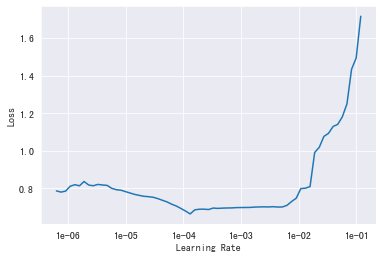

In [70]:
learn.recorder.plot()

In [74]:
# Fastai Learner object default optimizer is 'Adam', chose learning rate: 2e-5
lr = 2e-5

learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.606067,0.429434,0.825000,16:45
1,0.373766,0.268354,0.875000,16:40
2,0.244286,0.217554,0.925000,15:56
3,0.167072,0.220608,0.925000,16:08


In [75]:
learn.save('model_zh')

In [ ]:
learn.load('model_zh')

In [77]:
# unfreeze last 2 layer

learn.freeze_to(-2)

learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.145397,0.230978,0.895000,15:55


In [78]:
learn.save('model_0')

In [ ]:
learn.load('model_0')

### Train Learner #2 - learn_1 - RoBERTa model

[Ref](https://github.com/pytorch/fairseq/blob/master/examples/roberta/README.custom_classification.md)
For the fine-tuning, choosing the following values:

- Batch size: 8 - (MAX_SENTENCES)
- Learning rate (Adam): 1e-5
- Number of epochs: 10
- max_sql_len: 256

In [80]:
# the learning rate finder

learn_1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


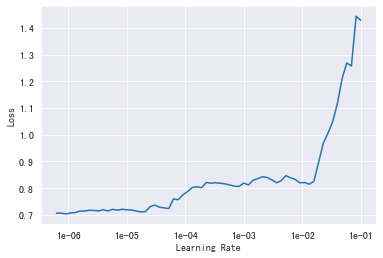

In [81]:
learn_1.recorder.plot()

In [82]:
# Fastai Learner object default optimizer is 'Adam'
lr = 1e-5

learn_1.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.683495,0.686389,0.560000,15:47
1,0.686334,0.726087,0.480000,15:43
2,0.630960,0.594314,0.700000,15:19
3,0.494644,0.608039,0.675000,15:34
4,0.386542,0.363813,0.835000,15:38
5,0.326270,0.529548,0.760000,15:39
6,0.273931,0.404787,0.865000,15:50
7,0.291830,0.365177,0.870000,15:39
8,0.245536,0.387809,0.870000,16:30
9,0.213473,0.362551,0.855000,15:42


In [83]:
learn_1.save('model_1')

In [ ]:
learn_1.load('model_1')

In [85]:
# unfreeze last 2 layer

learn_1.freeze_to(-2)

learn_1.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.286655,0.362558,0.860000,14:46


### Model Test

In [86]:
# helper function for test report

def h_prediction(n, model):
    preds = []
    for loc in range(n):
        preds.append(int(model.predict(test.iloc[loc]['comment'])[1]))
    return preds

In [87]:
# after training, make predictions on test data - BERT model

preds = h_prediction(len(test), learn)

print(classification_report(test.sentiment, preds))
print("confusion matrix: \n", confusion_matrix(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       103
           1       0.87      0.90      0.88        97

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.89       200

confusion matrix: 
 [[90 13]
 [10 87]]


In [88]:
# after training, make predictions on test data - RoBERTa model

preds_1 = h_prediction(len(test), learn_1)

print(classification_report(test.sentiment, preds_1))
print("confusion matrix: \n", confusion_matrix(test.sentiment, preds_1))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       103
           1       0.90      0.82      0.86        97

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200

confusion matrix: 
 [[94  9]
 [17 80]]


In [89]:
review_1 = "这家的环境差，菜也不好吃。"
print("BERT model:   ", learn.predict(review_1))
print("RoBERTa model:", learn_1.predict(review_1))

BERT model:    (Category 0, tensor(0), tensor([0.9762, 0.0238]))
RoBERTa model: (Category 0, tensor(0), tensor([0.8662, 0.1338]))


In [90]:
review_2 = "这家店的味道不错。"
print("BERT model:   ", learn.predict(review_2))
print("RoBERTa model:", learn_1.predict(review_2))

BERT model:    (Category 1, tensor(1), tensor([0.0176, 0.9824]))
RoBERTa model: (Category 1, tensor(1), tensor([0.0356, 0.9644]))


In [91]:
review_3 = "这家店的环境还可以，但是菜味道不行。"
print("BERT model:   ", learn.predict(review_3))
print("RoBERTa model:", learn_1.predict(review_3))

BERT model:    (Category 0, tensor(0), tensor([0.5832, 0.4168]))
RoBERTa model: (Category 0, tensor(0), tensor([0.8756, 0.1244]))


In [92]:
review_4 = "这家的环境不差，但是菜不怎么好吃。"
print("BERT model:   ", learn.predict(review_4))
print("RoBERTa model:", learn_1.predict(review_4))

BERT model:    (Category 0, tensor(0), tensor([0.9525, 0.0475]))
RoBERTa model: (Category 0, tensor(0), tensor([0.9925, 0.0075]))


In [ ]:
# first embedding layer weight of Bert 

bert_emb = bert_pretrained_model.bert.embeddings.word_embeddings.weight.detach().numpy()

In [ ]:
# visualize some samples in input space

labels = ['不','错','可','吃','味','道','好','没','有','的','菜','说','难','推','荐', 
             '咸','甜','太','级','差','强','快','意','义','一','二','般','极','慢']

word2int = [bert_tokenizer.vocab.get(v) for v in labels]

tokens = [emb_lstm[i] for i in word2int]

tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=1500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(8, 8)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()